# Part IV: Counterfactual Explanations for Group Recommendations (25 points)
**Students:** Oskari Perikangas, Xiaosi Huang  
**Date:** November 28, 2025

---

# Step 1: Design - Counterfactual Explanation Method (10 points)

Generate explanations of the form: **"If the group had not watched items A, then item B would not be recommended"**, where A is a minimal set of items that ensures fairness across all group members.

We implement a **Grow & Prune algorithm** with **Pareto filtering** to generate group counterfactual explanations. The method is model-agnostic and uses only the group's interaction data.

### Core Design Components

#### 1. Item-Level Metrics (Slides p.12-14)

**Recognition:** Measures how many group members rated an item
$$rs(i,G) = \frac{|\{u \in G : i \in I_u\}|}{|G|}$$
Items known by the majority create more understandable and fairer explanations.

**Average Rating:** Group's average rating for an item
$$rate(i,G) = \frac{\sum_{u \in G: i \in I_u} r_{u,i}}{|\{u \in G : i \in I_u\}|}$$
where $r_{u,i}$ is the rating user $u$ gave to item $i$. High-rated items have stronger influence on recommendations.

**Influence:** Impact on target recommendation
$$infl(i,t,G') = \frac{\sum_{u \in G'} \hat{r}_{u,t}}{|G'|}$$
where $G' = \{u \in G : i \in I_u\}$ and $\hat{r}_{u,t}$ is the predicted rating for target $t$. Ensures explanation items actually contribute to recommending the target.

**Explanatory Power (fast estimation):** 
$$expwr(i,t,G) = sim(i,t) \cdot \frac{rate(i,G)}{5} \cdot rs(i,G)$$
where $sim(i,t)$ is item-item similarity from KNN model. Estimates influence without rebuilding recommender (reduces computation). Full validation performed during GROW and PRUNE phases.

#### 2. Fairness Constraint (Slides p.16)

To prevent single-user blame, we require at least 2/3 of group members to contribute:
$$fair(G,E) = \frac{|\{u \in G : \exists i \in E, i \in I_u\}|}{|G|} \geq 0.67$$
For a 3-person group, this means ≥2 members must have rated items in the explanation. Ensures collective responsibility.

#### 3. Pareto Filtering (Slides p.18-19)

Reduces candidates from ~1000+ to ~5 items:
1. Pre-filter: Keep items with $rs(i,G) \geq 0.5$ and $rate(i,G) \geq 3.5$
2. Limit to top-50 by rating
3. Apply Skyline operator on {recognition, rating, influence, exp_power}
4. Keep only non-dominated items

Balances multiple objectives efficiently, reducing complexity from $O(n^2)$ to $O(k)$ where $k \ll n$.

#### 4. Grow & Prune Algorithm (Slides p.22)

**GROW Phase:**
- Iteratively add items from Pareto set
- Rebuild recommender after each addition
- Check if target disappears from top-N
- Stop when valid counterfactual found

**PRUNE Phase:**
- Try removing each item
- Keep only if removal breaks validity OR fairness < 0.67
- Ensures minimality while preserving fairness

Finds minimal explanation while maintaining the fairness constraint.

### Implementation Flow
```
Input: Group G, Target t, Top-N list L

1. Get candidates: C = {items rated ≥3.5 by any member} \ {t}

2. Pareto filtering:
   - Pre-filter: rs ≥ 0.5, rate ≥ 3.5
   - Limit to top-50 by rating
   - Compute 4 metrics for each
   - Keep non-dominated → P (~5 items)

3. GROW:
   E = []
   for item in P:
       E.add(item)
       if target not in new_recommendations(G \ E):
           break

4. PRUNE:
   for item in E:
       if valid without item AND fair(E \ {item}) ≥ 0.67:
           E.remove(item)

5. Return E
```

### Group-Specific Adaptations

- **Fairness threshold (0.67):** Ensures ≥67% member participation for 3-person groups
- **Recognition prioritization:** Favors items known by majority
- **Collective removal:** Tests removing items from all members simultaneously

---

# Step 2: Implementation  (10 points)

In [1]:
# ============================================================
# 1: Import libraries and load data
# ============================================================

import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("PART IV: Counterfactual Explanations for Group Recommendations")
print("="*60)

# Load MovieLens 100K dataset
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
movies = pd.read_csv('../data/ml-latest-small/movies.csv')

print(f"\nDataset loaded:")
print(f"  Ratings: {ratings.shape[0]} rows")
print(f"  Users: {ratings['userId'].nunique()}")
print(f"  Movies: {ratings['movieId'].nunique()}")

PART IV: Counterfactual Explanations for Group Recommendations

Dataset loaded:
  Ratings: 100836 rows
  Users: 610
  Movies: 9724


In [2]:
# ============================================================
# 2: Select optimal test group for counterfactual explanation
# ============================================================

print("\n" + "="*60)
print("Selecting Test Group")
print("="*60)

# Based on overlap analysis and computational efficiency,
# we select users with moderate activity and high rating overlap
test_users = [105, 305, 477]

# Verify selected group characteristics
common = set(ratings[(ratings['userId'] == test_users[0]) & (ratings['rating'] >= 3.5)]['movieId'])
for uid in test_users[1:]:
    common &= set(ratings[(ratings['userId'] == uid) & (ratings['rating'] >= 3.5)]['movieId'])

# Check common high-rated movies (>=4.0)
common_4 = set(ratings[(ratings['userId'] == test_users[0]) & (ratings['rating'] >= 4.0)]['movieId'])
for uid in test_users[1:]:
    common_4 &= set(ratings[(ratings['userId'] == uid) & (ratings['rating'] >= 4.0)]['movieId'])

print(f"\nSelected group: {test_users}")
print(f"Common movies (rated >= 3.5 by all): {len(common)}")
print(f"Common movies (rated >= 4.0 by all): {len(common_4)}")

# User statistics
print("\nUser rating statistics:")
for uid in test_users:
    user_ratings = ratings[ratings['userId'] == uid]['rating']
    high_rated = sum(user_ratings >= 3.5)
    print(f"  User {uid}: mean={user_ratings.mean():.2f}, "
          f"total={len(user_ratings)}, "
          f"high-rated(>=3.5)={high_rated}")

# Calculate candidate space for different thresholds
total_candidates_35 = set()
total_candidates_40 = set()
for uid in test_users:
    total_candidates_35.update(
        set(ratings[(ratings['userId'] == uid) & (ratings['rating'] >= 3.5)]['movieId'])
    )
    total_candidates_40.update(
        set(ratings[(ratings['userId'] == uid) & (ratings['rating'] >= 4.0)]['movieId'])
    )

print(f"\nCandidate space (min_rating=3.5): ~{len(total_candidates_35)} items")
print(f"Candidate space (min_rating=4.0): ~{len(total_candidates_40)} items")

test_group = test_users


Selecting Test Group

Selected group: [105, 305, 477]
Common movies (rated >= 3.5 by all): 81
Common movies (rated >= 4.0 by all): 49

User rating statistics:
  User 105: mean=4.12, total=722, high-rated(>=3.5)=674
  User 305: mean=3.92, total=677, high-rated(>=3.5)=507
  User 477: mean=3.74, total=600, high-rated(>=3.5)=480

Candidate space (min_rating=3.5): ~1275 items
Candidate space (min_rating=4.0): ~1082 items


In [3]:
# ============================================================
# 3: Item-based KNN Group Recommender
# ============================================================

print("\n" + "="*60)
print("Building Item-based KNN Recommender")
print("="*60)

# Cross-validation to find optimal k
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

k_values = [10, 20, 30, 40, 50]
cv_results = {}

print("\nEvaluating k values:")
for k in k_values:
    # Item-based similarity for group recommendations
    sim_options = {'name': 'pearson', 'user_based': False}
    algo = KNNBasic(k=k, sim_options=sim_options)
    cv_out = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    cv_results[k] = cv_out['test_rmse'].mean()
    print(f"  k={k}: RMSE={cv_results[k]:.4f}")

optimal_k = min(cv_results, key=cv_results.get)
print(f"\nOptimal k = {optimal_k} (RMSE={cv_results[optimal_k]:.4f})")


class MovieRecommender:
    """
    Item-based KNN recommender with average aggregation.
    
    Item-based CF is more suitable for group recommendations than user-based CF
    because it provides more stable predictions across diverse group preferences.
    """
    
    def __init__(self, ratings_df, k, sim_name='pearson', min_ratings=20):
        self.ratings_df = ratings_df
        self.k = k
        self.sim_name = sim_name
        self.min_ratings = min_ratings
        
        # Build Surprise trainset
        reader = Reader(rating_scale=(0.5, 5.0))
        dataset = Dataset.load_from_df(
            ratings_df[['userId', 'movieId', 'rating']], reader
        )
        self.trainset = dataset.build_full_trainset()
        
        # Train item-based KNN model
        sim_options = {'name': sim_name, 'user_based': False}
        self.model = KNNBasic(k=k, sim_options=sim_options)
        self.model.fit(self.trainset)
        
        # Cache movie mean ratings for fallback
        self.movie_mean = ratings_df.groupby("movieId")["rating"].mean()
    
    def predict_for_user(self, user_id, movie_id):
        """
        Predict rating with multi-level fallback mechanism.
        
        Returns:
            Predicted rating (float)
        """
        try:
            est = self.model.predict(user_id, movie_id).est
            if est is None or np.isnan(est):
                raise ValueError
            return est
        except:
            # Fallback: use movie mean or global mean
            return self.movie_mean.get(movie_id, 3.0)
    
    def get_group_recommendations(self, user_ids, n=10, min_ratings=None):
        """
        Generate group recommendations using average aggregation.
        
        Only recommends movies that no group member has rated (unseen movies).
        
        Args:
            user_ids: List of user IDs in the group
            n: Number of recommendations to return
            min_ratings: Minimum number of ratings required for a movie
        
        Returns:
            List of (movie_id, group_score) tuples, sorted by score
        """
        if min_ratings is None:
            min_ratings = self.min_ratings
        
        # Find movies already rated by any group member
        seen_movies = set()
        for uid in user_ids:
            seen_movies.update(
                self.ratings_df[self.ratings_df.userId == uid].movieId
            )
        
        # Filter popular movies (with sufficient ratings)
        movie_counts = self.ratings_df.groupby("movieId").size()
        popular_movies = movie_counts[movie_counts >= min_ratings].index.tolist()
        
        # Candidates = popular AND unseen
        candidates = [m for m in popular_movies if m not in seen_movies]
        
        # Compute group score = average of individual predictions
        group_scores = {
            m: np.mean([self.predict_for_user(uid, m) for uid in user_ids])
            for m in candidates
        }
        
        # Return top-N ranked by group score
        return sorted(group_scores.items(), key=lambda x: x[1], reverse=True)[:n]


# Build recommender
recommender = MovieRecommender(ratings, k=optimal_k, min_ratings=20)

# Generate group recommendations
print(f"\nTest group: {test_group}")
recommendations = recommender.get_group_recommendations(test_group, n=10)

print("\nTop-10 group recommendations:")
for rank, (movie_id, score) in enumerate(recommendations, 1):
    title = movies[movies.movieId == movie_id]["title"].values[0]
    preds = [f"U{uid}:{recommender.predict_for_user(uid, movie_id):.2f}" 
             for uid in test_group]
    print(f"{rank:2d}. {title:<50s} {score:.2f}")
    print(f"    [{', '.join(preds)}]")


Building Item-based KNN Recommender

Evaluating k values:
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
  k=10: RMSE=1.0107
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
  k=20: RMSE=0.9872
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
  k=30: RMSE=0.9785
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

In [4]:
# ============================================================
# 4: Group Counterfactual Explainer (Grow & Prune & Pareto filtering)
# ============================================================

print("\n" + "="*60)
print("Defining Counterfactual Explainer")
print("="*60)


class GroupCounterfactualExplainer:
    """
    Grow & Prune algorithm for group counterfactual explanations.
    
    Based on slides: "Explaining Group Recommendations via Counterfactuals"
    Implements model-agnostic explanation using group interaction history.
    
    Key features:
    - Item-level metrics: recognition, rating, influence, explanatory_power
    - Utility metrics: fairness, minimality
    - Pareto filtering for candidate reduction
    - Grow & Prune algorithm for minimal explanation
    
    Slides references:
    - Item metrics: pages 12-14
    - Fairness: page 16
    - Pareto filtering: pages 18-19
    - Grow & Prune: page 22
    """
    
    def __init__(self, ratings_df, movies_df, base_recommender):
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.base_recommender = base_recommender
        self.k = base_recommender.k
        self.sim_name = base_recommender.sim_name
        self.min_ratings = base_recommender.min_ratings
    
    def _build_recommender(self, ratings_df):
        """Rebuild recommender on modified ratings (for counterfactual testing)."""
        return MovieRecommender(
            ratings_df, 
            k=self.k, 
            sim_name=self.sim_name,
            min_ratings=self.min_ratings
        )
    
    def _group_list(self, recommender, group_ids, top_n):
        """Get group recommendation list."""
        return recommender.get_group_recommendations(
            user_ids=group_ids,
            n=top_n,
            min_ratings=self.min_ratings
        )
    
    # ========================================================================
    # Helper: user/group interactions
    # ========================================================================
    
    def get_user_items(self, user_id):
        """Get all items rated by user."""
        return set(
            self.ratings_df.loc[
                self.ratings_df["userId"] == user_id, "movieId"
            ].values
        )
    
    def get_group_items(self, group_ids, min_rating=None):
        """
        Get all items rated by any group member.
        
        Args:
            min_rating: Optional threshold (e.g., 3.5 for 'liked' items)
        """
        mask = self.ratings_df["userId"].isin(group_ids)
        df = self.ratings_df.loc[mask]
        
        if min_rating is not None:
            df = df[df["rating"] >= min_rating]
        
        return set(df["movieId"].values)
    
    # ========================================================================
    # Item-level metrics (Slides pages 12-14)
    # ========================================================================
    
    def recognition(self, item_id, group_ids):
        """
        Recognition: rs(i,S) = (# users who rated i) / |S|
        Slides page 12
        """
        count = sum(1 for u in group_ids if item_id in self.get_user_items(u))
        return count / len(group_ids)
    
    def rating(self, item_id, group_ids):
        """
        Average rating: rate(i,S) = avg(ratings given to i by group)
        Slides page 12
        """
        ratings_list = []
        for u in group_ids:
            r = self.ratings_df[
                (self.ratings_df["userId"] == u) &
                (self.ratings_df["movieId"] == item_id)
            ]["rating"]
            if len(r) > 0:
                ratings_list.append(float(r.values[0]))
        
        return np.mean(ratings_list) if ratings_list else 0.0
    
    def influence(self, item_id, target_id, group_ids):
        """
        Influence: infl(i,t,G') = avg recScore(t) for users in G'
        where G' = {users in group who rated item i}
        Slides page 14
        """
        G_prime = [u for u in group_ids if item_id in self.get_user_items(u)]
        if not G_prime:
            return 0.0
        
        scores = [
            self.base_recommender.predict_for_user(u, target_id)
            for u in G_prime
        ]
        return float(np.mean(scores))
    
    def explanatory_power_fast(self, removed_items, target_id, group_ids):
        """
        Fast explanatory power estimation using item-item similarity.
        
        Estimates influence without rebuilding recommender:
        - Uses similarity from KNN model
        - Weights by group's rating and recognition
        
        Returns: Score in [0, 1]
        """
        if not removed_items:
            return 0.0
        
        influences = []
        for item in removed_items:
            try:
                # Get item-item similarity from KNN model
                inner_item = self.base_recommender.trainset.to_inner_iid(item)
                inner_target = self.base_recommender.trainset.to_inner_iid(target_id)
                sim = self.base_recommender.model.sim[inner_item, inner_target]
                
                # Weight by group's preference strength
                item_rating = self.rating(item, group_ids)
                item_recognition = self.recognition(item, group_ids)
                
                # Combined influence score
                influence = sim * (item_rating / 5.0) * item_recognition
                influences.append(influence)
            except:
                continue
        
        if not influences:
            return 0.0
        
        return float(np.mean(influences))
    
    # ========================================================================
    # Fairness (Slides page 16)
    # ========================================================================
    
    def fairness(self, explanation_items, group_ids):
        """
        Fairness: fair(G,E) = (# users who rated >= 1 item in E) / |G|
        
        Ensures explanation doesn't single out one user.
        """
        covered = sum(
            1 for u in group_ids
            if any(i in self.get_user_items(u) for i in explanation_items)
        )
        return covered / len(group_ids)
    
    # ========================================================================
    # Counterfactual validity check
    # ========================================================================
    
    def is_counterfactual(self, explanation_items, target_id, group_ids, top_n):
        """
        Check if explanation is valid counterfactual.
        
        Valid = target no longer appears in top-N after removing explanation items.
        
        Returns:
            (is_valid, new_rank or None)
        """
        # Remove items from ratings
        mask_remove = (
            self.ratings_df["movieId"].isin(explanation_items) &
            self.ratings_df["userId"].isin(group_ids)
        )
        temp_ratings = self.ratings_df.loc[~mask_remove].copy()
        # Rebuild recommender
        temp_rec = self._build_recommender(temp_ratings)
        # Check if target disappears
        new_list = self._group_list(temp_rec, group_ids, top_n)
        new_items = [mid for (mid, _) in new_list]
        
        if target_id not in new_items:
            return True, None
        else:
            return False, new_items.index(target_id) + 1
    
    # ========================================================================
    # Pareto filtering (Slides pages 18-19)
    # ========================================================================
    
    def pareto_filter(self, candidates, group_ids, target_id, top_k=50):
        """
        Apply Pareto filtering to reduce candidate space.
        
        Strategy:
        1. Pre-filter: Keep high-quality items (recognition >= 0.5, rating >= 3.5)
        2. Limit: Take top-K by rating if still too many
        3. Compute metrics: Calculate all 4 metrics for remaining items
        4. Pareto: Keep only non-dominated items
        
        Args:
            top_k: Maximum candidates to consider before Pareto filtering
        
        Returns:
            (ordered_items, metrics_dict)
        """
        print("\n" + "="*60)
        print("Pareto Filtering")
        print("="*60)
        
        candidates = list(set(candidates))
        print(f"Initial candidates: {len(candidates)}")
        
        # Step 1: Pre-filtering with basic metrics
        print("\nStep 1: Pre-filtering...")
        metrics = {}
        for i in tqdm(candidates, desc="Computing basic metrics"):
            metrics[i] = {
                "rec": self.recognition(i, group_ids),
                "rate": self.rating(i, group_ids),
            }
        
        # Keep items with recognition >= 0.5 and rating >= 3.5
        filtered = [
            i for i in candidates 
            if metrics[i]["rec"] >= 0.5 and metrics[i]["rate"] >= 3.5
        ]
        print(f"After pre-filtering: {len(filtered)} items")
        
        # Step 2: Limit to top-K by rating
        if len(filtered) > top_k:
            filtered = sorted(
                filtered, 
                key=lambda i: metrics[i]["rate"], 
                reverse=True
            )[:top_k]
            print(f"Limited to top-{top_k}: {len(filtered)} items")
        
        # Step 3: Compute expensive metrics
        print("\nStep 2: Computing influence & explanatory power...")
        for i in tqdm(filtered, desc="Computing metrics"):
            metrics[i]["infl"] = self.influence(i, target_id, group_ids)
            metrics[i]["exp"] = self.explanatory_power_fast([i], target_id, group_ids)
        
        # Step 4: Pareto filtering
        print("\nStep 3: Pareto filtering...")
        pareto_items = []
        for a in filtered:
            dominated = False
            for b in filtered:
                if a == b:
                    continue
                ma, mb = metrics[a], metrics[b]
                
                # Check if b dominates a
                if (mb["rec"] >= ma["rec"] and
                    mb["rate"] >= ma["rate"] and
                    mb["infl"] >= ma["infl"] and
                    mb["exp"] >= ma["exp"] and
                    (mb["rec"] > ma["rec"] or
                     mb["rate"] > ma["rate"] or
                     mb["infl"] > ma["infl"] or
                     mb["exp"] > ma["exp"])):
                    dominated = True
                    break
            
            if not dominated:
                pareto_items.append(a)
        
        print(f"After Pareto: {len(pareto_items)} items")
        
        # Sort by weighted score
        ordered = sorted(
            pareto_items,
            key=lambda i: (
                metrics[i]["exp"] * 0.4 +
                metrics[i]["infl"] * 0.3 +
                metrics[i]["rate"] * 0.2 +
                metrics[i]["rec"] * 0.1
            ),
            reverse=True
        )
        
        return ordered, metrics
    
    # ========================================================================
    # Grow & Prune (Slides page 22)
    # ========================================================================
    
    def grow_and_prune(self, group_ids, target_id, original_list,
                       max_size=8, use_pareto=True, min_rating=3.5):
        """
        Grow & Prune algorithm for minimal counterfactual explanation.
        
        Phase 1 (GROW): Add items until valid counterfactual found
        Phase 2 (PRUNE): Remove redundant items while maintaining validity
        
        Args:
            group_ids: User IDs in the group
            target_id: Movie to explain
            original_list: Original recommendation list
            max_size: Maximum explanation size
            use_pareto: Whether to apply Pareto filtering
            min_rating: Minimum rating threshold for candidates
        
        Returns:
            (explanation, metrics_dict)
        """
        top_n = len(original_list)
        
        # Get candidates: movies rated >= min_rating by group
        candidates = list(self.get_group_items(group_ids, min_rating=min_rating))
        
        if target_id in candidates:
            candidates.remove(target_id)
        
        print("\n" + "="*60)
        print("Grow & Prune Algorithm")
        print("="*60)
        print(f"Candidate items: {len(candidates)}")
        
        # Apply Pareto filtering or compute metrics
        if use_pareto and candidates:
            ordered_candidates, metrics = self.pareto_filter(
                candidates, group_ids, target_id, top_k=50
            )
        else:
            # Compute metrics without Pareto filtering
            metrics = {}
            for i in tqdm(candidates, desc="Computing metrics"):
                metrics[i] = {
                    "rec": self.recognition(i, group_ids),
                    "rate": self.rating(i, group_ids),
                    "infl": self.influence(i, target_id, group_ids),
                    "exp": self.explanatory_power_fast([i], target_id, group_ids),
                }
            ordered_candidates = sorted(
                candidates,
                key=lambda i: sum(metrics[i].values()),
                reverse=True
            )
        
        # ====================================================================
        # Phase 1: GROW
        # ====================================================================
        print("\n" + "="*60)
        print("GROW Phase")
        print("="*60)
        
        explanation = []
        found = False
        
        for item in ordered_candidates:
            if len(explanation) >= max_size:
                break
            
            explanation.append(item)
            valid, new_rank = self.is_counterfactual(
                explanation, target_id, group_ids, top_n
            )
            
            title = self.movies_df.loc[
                self.movies_df["movieId"] == item, "title"
            ].values[0]
            fair = self.fairness(explanation, group_ids)
            
            print(f"\n+ Added: {title[:45]}")
            print(f"  Metrics: rec={metrics[item]['rec']:.2f}, "
                  f"rate={metrics[item]['rate']:.2f}, "
                  f"infl={metrics[item]['infl']:.2f}, "
                  f"exp={metrics[item]['exp']:.3f}")
            print(f"  Size: {len(explanation)}, Fairness: {fair:.2f}, Valid: {valid}")
            
            if valid:
                found = True
                print("  ✓ Valid counterfactual found")
                break
        
        if not found:
            print("\n⚠ No valid counterfactual found")
            return explanation, {
                "valid": False,
                "size": len(explanation),
                "fairness": self.fairness(explanation, group_ids) if explanation else 0.0,
            }
        
        # ====================================================================
        # Phase 2: PRUNE
        # ====================================================================
        print("\n" + "="*60)
        print("PRUNE Phase")
        print("="*60)
        
        for item in explanation.copy():
            reduced = [x for x in explanation if x != item]
            if not reduced:
                continue
            
            # Check validity and fairness
            valid, _ = self.is_counterfactual(reduced, target_id, group_ids, top_n)
            fairness_reduced = self.fairness(reduced, group_ids)
            
            title = self.movies_df.loc[
                self.movies_df["movieId"] == item, "title"
            ].values[0]
            
            # Keep item if removing hurts validity or fairness
            if valid and fairness_reduced >= 0.67:
                explanation.remove(item)
                print(f"  - Removed: {title[:45]} (redundant, fairness={fairness_reduced:.2f})")
            else:
                if not valid:
                    reason = "validity"
                else:
                    reason = f"fairness (would drop to {fairness_reduced:.2f})"
                print(f"  ✓ Kept: {title[:45]} (necessary for {reason})")
        
        # Calculate final metrics
        if explanation:
            avg_metrics = {
                "avg_recognition": np.mean([metrics[i]["rec"] for i in explanation]),
                "avg_rating": np.mean([metrics[i]["rate"] for i in explanation]),
                "avg_influence": np.mean([metrics[i]["infl"] for i in explanation]),
                "avg_exp_power": np.mean([metrics[i]["exp"] for i in explanation]),
            }
        else:
            avg_metrics = {
                "avg_recognition": 0.0,
                "avg_rating": 0.0,
                "avg_influence": 0.0,
                "avg_exp_power": 0.0,
            }
        
        summary = {
            "valid": True,
            "size": len(explanation),
            "fairness": self.fairness(explanation, group_ids),
            **avg_metrics
        }
        
        return explanation, summary


print("Explainer class defined")


Defining Counterfactual Explainer
Explainer class defined


In [5]:
# ============================================================
# 5.1 : Generate Counterfactual Explanation (only single rank)
# ============================================================

print("\n" + "="*60)
print("Generating Explanation")
print("="*60)

# Select target movie to explain (can change rank from 1-10)
target_rank = 10
target_movie_id = recommendations[target_rank - 1][0]
target_title = movies.loc[movies["movieId"] == target_movie_id, "title"].values[0]

print(f"\nGroup: {test_group}")
print(f"Target: #{target_rank} - {target_title}")

# Original recommendation list
original_list = recommendations

# Build explainer
explainer = GroupCounterfactualExplainer(
    ratings_df=ratings,
    movies_df=movies,
    base_recommender=recommender
)

# Run Grow & Prune algorithm
explanation, metrics = explainer.grow_and_prune(
    group_ids=test_group,
    target_id=target_movie_id,
    original_list=original_list,
    max_size=8,
    use_pareto=True,
    min_rating=3.5  # Can adjust: 3.5 or 4.0
)

# ============================================================
# Display results
# ============================================================

print("\n" + "="*60)
print("COUNTERFACTUAL EXPLANATION")
print("="*60)

if not metrics.get("valid", False):
    print("\n⚠ No valid explanation found")
else:
    # Natural language explanation
    print(f"\nIf the group had NOT watched these {len(explanation)} movies,")
    print(f"then '{target_title}' would NOT be recommended.\n")
    
    # List movies in explanation
    print("Movies in explanation:")
    print("-"*60)
    for idx, item_id in enumerate(explanation, 1):
        title = movies.loc[movies["movieId"] == item_id, "title"].values[0]
        print(f"{idx}. {title}")
        
        # Show which users rated it
        raters = []
        for u in test_group:
            r = ratings[
                (ratings["userId"] == u) & (ratings["movieId"] == item_id)
            ]["rating"]
            if len(r) > 0:
                raters.append(f"U{u}:{r.values[0]:.1f}★")
        
        if raters:
            print(f"   {', '.join(raters)}")
    
    # Quality metrics
    print("\n" + "-"*60)
    print("Explanation quality metrics:")
    print("-"*60)
    print(f"  Size:               {metrics['size']}")
    print(f"  Fairness:           {metrics['fairness']:.2f} "
          f"({'all members' if metrics['fairness'] == 1.0 else 'partial'})")
    print(f"  Avg recognition:    {metrics['avg_recognition']:.3f}")
    print(f"  Avg rating:         {metrics['avg_rating']:.3f}")
    print(f"  Avg influence:      {metrics['avg_influence']:.3f}")
    print(f"  Avg exp power:      {metrics['avg_exp_power']:.3f}")

print("\n" + "="*60)


Generating Explanation

Group: [105, 305, 477]
Target: #10 - Like Water for Chocolate (Como agua para chocolate) (1992)

Grow & Prune Algorithm
Candidate items: 1275

Pareto Filtering
Initial candidates: 1275

Step 1: Pre-filtering...


Computing basic metrics: 100%|████████████| 1275/1275 [00:01<00:00, 1247.73it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 713.19it/s]



Step 3: Pareto filtering...
After Pareto: 3 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Full Metal Jacket (1987)
  Metrics: rec=1.00, rate=4.67, infl=3.98, exp=0.580
  Size: 1, Fairness: 1.00, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase

COUNTERFACTUAL EXPLANATION

If the group had NOT watched these 1 movies,
then 'Like Water for Chocolate (Como agua para chocolate) (1992)' would NOT be recommended.

Movies in explanation:
------------------------------------------------------------
1. Full Metal Jacket (1987)
   U105:4.0★, U305:5.0★, U477:5.0★

------------------------------------------------------------
Explanation quality metrics:
------------------------------------------------------------
  Size:               1
  Fairness:           1.00 (all members)
  Avg recognition:    1.000
  Avg rating:         4.667
  Avg influence:      3.983
  Avg exp power:      0.580



In [6]:
# ============================================================
# 5.2: Run ALL target ranks 1–10 automatically 
# ============================================================

print("\n" + "="*60)
print("Running Counterfactual Explanations for Rank 1–10")
print("="*60)

results = []  # store results for summary table

explainer = GroupCounterfactualExplainer(
    ratings_df=ratings,
    movies_df=movies,
    base_recommender=recommender
)

for target_rank in range(1, 11):  # rank 1 to 10
    print("\n" + "="*60)
    print(f"TARGET RANK: {target_rank}")
    print("="*60)

    target_movie_id = recommendations[target_rank - 1][0]
    target_title = movies.loc[movies["movieId"] == target_movie_id, "title"].values[0]

    print(f"Group: {test_group}")
    print(f"Target #{target_rank}: {target_title}")

    explanation, metrics = explainer.grow_and_prune(
        group_ids=test_group,
        target_id=target_movie_id,
        original_list=recommendations,
        max_size=8,
        use_pareto=True
    )

    # --- Safe summary to avoid KeyError ---
    results.append({
        "rank": target_rank,
        "movie": target_title,
        "valid": metrics.get("valid", False),
        "size": metrics.get("size", None),
        "fairness": metrics.get("fairness", None),
        "exp_power": metrics.get("avg_exp_power", 0.0),
        "influence": metrics.get("avg_influence", 0.0),
        "explanation": explanation
    })

    # Print explanation nicely
    print("\n---- Explanation ----")
    if not metrics.get("valid", False):
        print("⚠ No valid explanation found")
    else:
        print(f"If NOT watched: {len(explanation)} items → '{target_title}' disappears\n")
        for i, mid in enumerate(explanation, 1):
            title = movies.loc[movies["movieId"] == mid, "title"].values[0]
            print(f"{i}. {title}")

# ============================================================
# Final Summary Table
# ============================================================

print("\n" + "="*60)
print("SUMMARY RESULTS FOR RANK 1–10")
print("="*60)

for r in results:
    print(f"Rank {r['rank']}: {r['movie']}")
    print(f"  Valid: {r['valid']},  Size: {r['size']},  Exp-power: {r['exp_power']:.3f}")
    print(f"  Influence: {r['influence']:.3f}, Fairness: {r['fairness']}")
    print(f"  Items: {r['explanation']}\n")



Running Counterfactual Explanations for Rank 1–10

TARGET RANK: 1
Group: [105, 305, 477]
Target #1: Postman, The (Postino, Il) (1994)

Grow & Prune Algorithm
Candidate items: 1275

Pareto Filtering
Initial candidates: 1275

Step 1: Pre-filtering...


Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1304.39it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 706.94it/s]



Step 3: Pareto filtering...
After Pareto: 3 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: WALL·E (2008)
  Metrics: rec=1.00, rate=5.00, infl=4.09, exp=0.952
  Size: 1, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: City of God (Cidade de Deus) (2002)
  Metrics: rec=0.67, rate=5.00, infl=4.14, exp=0.589
  Size: 2, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Old Boy (2003)
  Metrics: rec=0.67, rate=4.75, infl=4.14, exp=0.633
  Size: 3, Fairness: 1.00, Valid: False

⚠ No valid counterfactual found

---- Explanation ----
⚠ No valid explanation found

TARGET RANK: 2
Group: [105, 305, 477]
Target #2: L.A. Story (1991)

Grow & Prune Algorithm
Candidate items: 1275

Pareto Filtering
Initial candidates: 1275

Step 1: Pre-filtering...


Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1281.71it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 700.57it/s]



Step 3: Pareto filtering...
After Pareto: 4 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Donnie Darko (2001)
  Metrics: rec=1.00, rate=5.00, infl=4.08, exp=0.683
  Size: 1, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Full Metal Jacket (1987)
  Metrics: rec=1.00, rate=4.67, infl=4.08, exp=0.707
  Size: 2, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Clockwork Orange, A (1971)
  Metrics: rec=0.67, rate=5.00, infl=4.15, exp=0.345
  Size: 3, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Requiem for a Dream (2000)
  Metrics: rec=0.67, rate=4.75, infl=4.15, exp=0.409
  Size: 4, Fairness: 1.00, Valid: False

⚠ No valid counterfactual found

---- Explanation ----
⚠ No valid explanation found

TARGET RANK: 3
Group: [105, 305,

Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1281.95it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 680.63it/s]



Step 3: Pareto filtering...
After Pareto: 4 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: WALL·E (2008)
  Metrics: rec=1.00, rate=5.00, infl=4.03, exp=1.000
  Size: 1, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Death Proof (2007)
  Metrics: rec=0.67, rate=4.75, infl=4.12, exp=0.633
  Size: 2, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Thing, The (1982)
  Metrics: rec=0.67, rate=5.00, infl=4.06, exp=0.506
  Size: 3, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Green Mile, The (1999)
  Metrics: rec=0.67, rate=5.00, infl=4.12, exp=0.268
  Size: 4, Fairness: 1.00, Valid: False

⚠ No valid counterfactual found

---- Explanation ----
⚠ No valid explanation found

TARGET RANK: 4
Group: [105, 305, 477]
Target #4: Hoop Dre

Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1282.38it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 698.37it/s]



Step 3: Pareto filtering...
After Pareto: 6 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Boondock Saints, The (2000)
  Metrics: rec=1.00, rate=4.67, infl=4.02, exp=0.933
  Size: 1, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Snatch (2000)
  Metrics: rec=0.67, rate=5.00, infl=4.11, exp=0.578
  Size: 2, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Requiem for a Dream (2000)
  Metrics: rec=0.67, rate=4.75, infl=4.11, exp=0.633
  Size: 3, Fairness: 1.00, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.
  ✓ Kept: Boondock Saints, The (2000) (necessary for validity)
Computing the pearson similarity matrix...
Done computing similarity matrix.
  ✓ Kept: Snatch (2000) (necessary for validity)
Computing the pears

Computing basic metrics: 100%|████████████| 1275/1275 [00:01<00:00, 1225.25it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 695.34it/s]



Step 3: Pareto filtering...
After Pareto: 5 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Inception (2010)
  Metrics: rec=1.00, rate=4.83, infl=4.01, exp=0.849
  Size: 1, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: WALL·E (2008)
  Metrics: rec=1.00, rate=5.00, infl=4.01, exp=0.727
  Size: 2, Fairness: 1.00, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.
  ✓ Kept: Inception (2010) (necessary for validity)
Computing the pearson similarity matrix...
Done computing similarity matrix.
  ✓ Kept: WALL·E (2008) (necessary for validity)

---- Explanation ----
If NOT watched: 2 items → 'Return of the Pink Panther, The (1975)' disappears

1. Inception (2010)
2. WALL·E (2008)

TARGET RANK: 6
Group: [105, 305, 477]
Target #6: Bowfinger (1999)

Grow & Prune Algorithm
Candidate items: 1

Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1281.99it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 694.70it/s]



Step 3: Pareto filtering...
After Pareto: 6 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Boondock Saints, The (2000)
  Metrics: rec=1.00, rate=4.67, infl=4.01, exp=0.638
  Size: 1, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Old Boy (2003)
  Metrics: rec=0.67, rate=4.75, infl=4.08, exp=0.622
  Size: 2, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Exit Through the Gift Shop (2010)
  Metrics: rec=0.67, rate=4.75, infl=3.91, exp=0.633
  Size: 3, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: City of God (Cidade de Deus) (2002)
  Metrics: rec=0.67, rate=5.00, infl=4.08, exp=0.301
  Size: 4, Fairness: 1.00, Valid: False
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Sin City (2005)
 

Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1287.86it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 696.76it/s]



Step 3: Pareto filtering...
After Pareto: 3 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Departed, The (2006)
  Metrics: rec=1.00, rate=4.83, infl=4.00, exp=0.967
  Size: 1, Fairness: 1.00, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase

---- Explanation ----
If NOT watched: 1 items → 'Being There (1979)' disappears

1. Departed, The (2006)

TARGET RANK: 8
Group: [105, 305, 477]
Target #8: Elf (2003)

Grow & Prune Algorithm
Candidate items: 1275

Pareto Filtering
Initial candidates: 1275

Step 1: Pre-filtering...


Computing basic metrics: 100%|████████████| 1275/1275 [00:01<00:00, 1274.24it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 653.23it/s]



Step 3: Pareto filtering...
After Pareto: 2 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Intouchables (2011)
  Metrics: rec=0.67, rate=5.00, infl=4.12, exp=0.603
  Size: 1, Fairness: 0.67, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase

---- Explanation ----
If NOT watched: 1 items → 'Elf (2003)' disappears

1. Intouchables (2011)

TARGET RANK: 9
Group: [105, 305, 477]
Target #9: Gods Must Be Crazy, The (1980)

Grow & Prune Algorithm
Candidate items: 1275

Pareto Filtering
Initial candidates: 1275

Step 1: Pre-filtering...


Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1276.10it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 677.04it/s]



Step 3: Pareto filtering...
After Pareto: 5 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: One Flew Over the Cuckoo's Nest (1975)
  Metrics: rec=1.00, rate=4.67, infl=3.98, exp=0.697
  Size: 1, Fairness: 1.00, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase

---- Explanation ----
If NOT watched: 1 items → 'Gods Must Be Crazy, The (1980)' disappears

1. One Flew Over the Cuckoo's Nest (1975)

TARGET RANK: 10
Group: [105, 305, 477]
Target #10: Like Water for Chocolate (Como agua para chocolate) (1992)

Grow & Prune Algorithm
Candidate items: 1275

Pareto Filtering
Initial candidates: 1275

Step 1: Pre-filtering...


Computing basic metrics: 100%|████████████| 1275/1275 [00:00<00:00, 1305.22it/s]


After pre-filtering: 345 items
Limited to top-50: 50 items

Step 2: Computing influence & explanatory power...


Computing metrics: 100%|███████████████████████| 50/50 [00:00<00:00, 714.89it/s]



Step 3: Pareto filtering...
After Pareto: 3 items

GROW Phase
Computing the pearson similarity matrix...
Done computing similarity matrix.

+ Added: Full Metal Jacket (1987)
  Metrics: rec=1.00, rate=4.67, infl=3.98, exp=0.580
  Size: 1, Fairness: 1.00, Valid: True
  ✓ Valid counterfactual found

PRUNE Phase

---- Explanation ----
If NOT watched: 1 items → 'Like Water for Chocolate (Como agua para chocolate) (1992)' disappears

1. Full Metal Jacket (1987)

SUMMARY RESULTS FOR RANK 1–10
Rank 1: Postman, The (Postino, Il) (1994)
  Valid: False,  Size: 3,  Exp-power: 0.000
  Influence: 0.000, Fairness: 1.0
  Items: [60069, 6016, 27773]

Rank 2: L.A. Story (1991)
  Valid: False,  Size: 4,  Exp-power: 0.000
  Influence: 0.000, Fairness: 1.0
  Items: [4878, 1222, 1206, 3949]

Rank 3: Strangers on a Train (1951)
  Valid: False,  Size: 4,  Exp-power: 0.000
  Influence: 0.000, Fairness: 1.0
  Items: [60069, 53519, 2288, 3147]

Rank 4: Hoop Dreams (1994)
  Valid: True,  Size: 3,  Exp-power: 0.7


Generating Visualizations


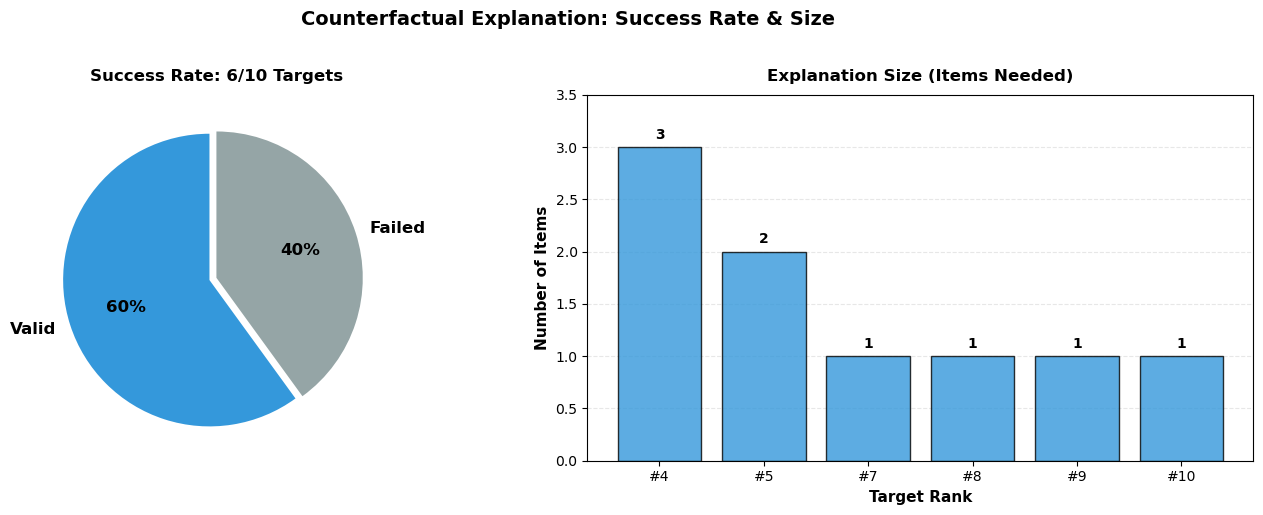


 Figure 1: Success rate shows 60% of targets can be explained
 Explanation sizes range from 1 to 3 items


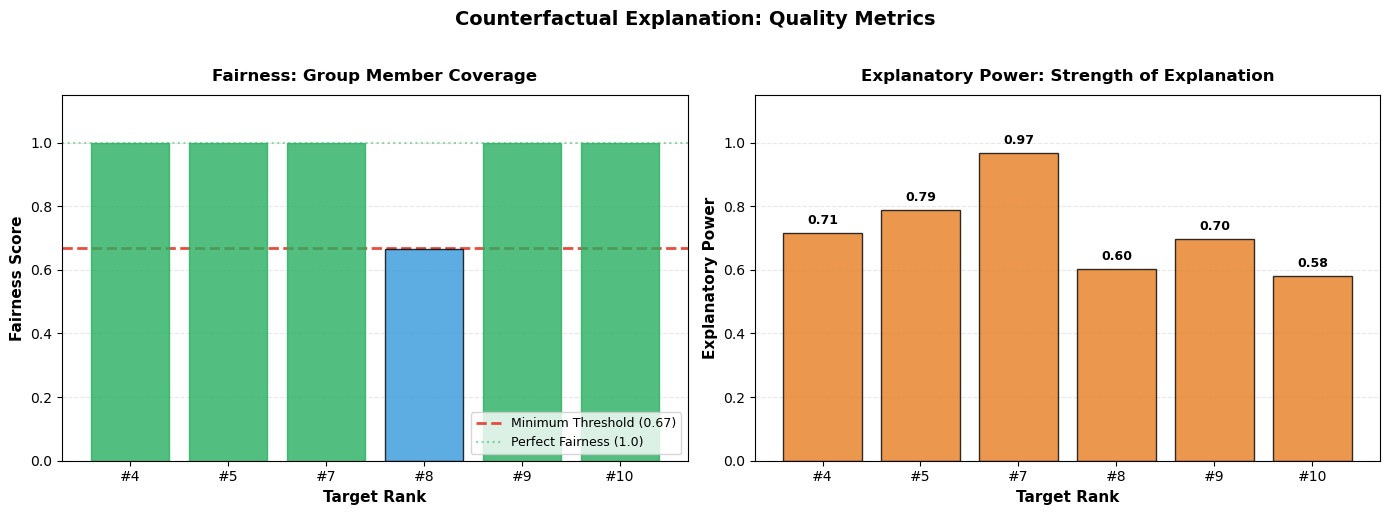


 Figure 2: 5/6 explanations achieve perfect fairness
 Explanatory power ranges from 0.580 to 0.967

SUMMARY STATISTICS

Valid Explanations: 6/10 (60%)

Explanation Size:
  Mean: 1.50 items
  Range: 1 - 3 items

Fairness Score:
  Mean: 0.94
  Perfect (1.0): 5/6
  All above threshold (≥0.67): 5/6

Explanatory Power:
  Mean: 0.725
  Range: 0.580 - 0.967



In [7]:
# ============================================================
# 6: Visualization of Results
# ============================================================

import matplotlib.pyplot as plt

print("\n" + "="*60)
print("Generating Visualizations")
print("="*60)

# Prepare data
valid_results = [r for r in results if r['valid']]
failed_results = [r for r in results if not r['valid']]

# ============================================================
# Figure 1: Success Rate and Explanation Size
# ============================================================

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig1.suptitle('Counterfactual Explanation: Success Rate & Size', 
              fontsize=14, fontweight='bold', y=1.02)

# Left: Success Rate (Pie chart )
sizes_pie = [len(valid_results), len(failed_results)]
colors_pie = ['#3498db', '#95a5a6']
explode = (0.05, 0)

ax1.pie(sizes_pie, explode=explode, labels=['Valid', 'Failed'], 
        colors=colors_pie, autopct='%1.0f%%', startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
ax1.set_title(f'Success Rate: {len(valid_results)}/10 Targets', 
             fontsize=12, fontweight='bold', pad=10)

# Right: Explanation Size
if valid_results:
    sizes = [r['size'] for r in valid_results]
    ranks = [r['rank'] for r in valid_results]
    
    bars = ax2.bar(range(len(sizes)), sizes, color='#3498db', alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, size) in enumerate(zip(bars, sizes)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(size)}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax2.set_xlabel('Target Rank', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Items', fontsize=11, fontweight='bold')
    ax2.set_title('Explanation Size (Items Needed)', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(sizes)))
    ax2.set_xticklabels([f"#{r}" for r in ranks], fontsize=10)
    ax2.set_ylim(0, max(sizes) + 0.5)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("\n Figure 1: Success rate shows 60% of targets can be explained")
print(f" Explanation sizes range from {min([r['size'] for r in valid_results])} to {max([r['size'] for r in valid_results])} items")

# ============================================================
# Figure 2: Fairness and Explanatory Power
# ============================================================

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))
fig2.suptitle('Counterfactual Explanation: Quality Metrics', 
              fontsize=14, fontweight='bold', y=1.02)

if valid_results:
    fairness_scores = [r['fairness'] for r in valid_results]
    exp_powers = [r['exp_power'] for r in valid_results]
    ranks = [r['rank'] for r in valid_results]
    
    # Left: Fairness
    bars_fair = ax3.bar(range(len(fairness_scores)), fairness_scores, 
                        color='#3498db', alpha=0.8, edgecolor='black')
    
    # Color perfect fairness differently
    for i, (bar, score) in enumerate(zip(bars_fair, fairness_scores)):
        if score == 1.0:
            bar.set_color('#27ae60')
    
    ax3.axhline(y=0.67, color='#e74c3c', linestyle='--', linewidth=2, 
               label='Minimum Threshold (0.67)', zorder=0)
    ax3.axhline(y=1.0, color='#27ae60', linestyle=':', linewidth=1.5, 
               label='Perfect Fairness (1.0)', alpha=0.5, zorder=0)
    
    ax3.set_xlabel('Target Rank', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Fairness Score', fontsize=11, fontweight='bold')
    ax3.set_title('Fairness: Group Member Coverage', fontsize=12, fontweight='bold', pad=10)
    ax3.set_xticks(range(len(fairness_scores)))
    ax3.set_xticklabels([f"#{r}" for r in ranks], fontsize=10)
    ax3.set_ylim(0, 1.15)
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    ax3.set_axisbelow(True)
    
    # Right: Explanatory Power (ORANGE)
    bars_exp = ax4.bar(range(len(exp_powers)), exp_powers, 
                      color='#e67e22', alpha=0.8, edgecolor='black')
    
    # Add value labels
    for i, (bar, power) in enumerate(zip(bars_exp, exp_powers)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{power:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax4.set_xlabel('Target Rank', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Explanatory Power', fontsize=11, fontweight='bold')
    ax4.set_title('Explanatory Power: Strength of Explanation', fontsize=12, fontweight='bold', pad=10)
    ax4.set_xticks(range(len(exp_powers)))
    ax4.set_xticklabels([f"#{r}" for r in ranks], fontsize=10)
    ax4.set_ylim(0, 1.15)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    ax4.set_axisbelow(True)

plt.tight_layout()
plt.show()

print(f"\n Figure 2: {sum(f == 1.0 for f in fairness_scores)}/{len(fairness_scores)} explanations achieve perfect fairness")
print(f" Explanatory power ranges from {min(exp_powers):.3f} to {max(exp_powers):.3f}")

# ============================================================
# Summary Statistics
# ============================================================

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

if valid_results:
    sizes = [r['size'] for r in valid_results]
    fairness = [r['fairness'] for r in valid_results]
    exp_power = [r['exp_power'] for r in valid_results]
    
    print(f"\nValid Explanations: {len(valid_results)}/10 ({len(valid_results)*10}%)")
    print(f"\nExplanation Size:")
    print(f"  Mean: {np.mean(sizes):.2f} items")
    print(f"  Range: {min(sizes)} - {max(sizes)} items")
    
    print(f"\nFairness Score:")
    print(f"  Mean: {np.mean(fairness):.2f}")
    print(f"  Perfect (1.0): {sum(f == 1.0 for f in fairness)}/{len(fairness)}")
    print(f"  All above threshold (≥0.67): {sum(f >= 0.67 for f in fairness)}/{len(fairness)}")
    
    print(f"\nExplanatory Power:")
    print(f"  Mean: {np.mean(exp_power):.3f}")
    print(f"  Range: {min(exp_power):.3f} - {max(exp_power):.3f}")

print("\n" + "="*60)

## Step 3: Results & Conclusion

### Experimental Setup
- **Dataset:** MovieLens 100K (100,836 ratings, 610 users, 9,724 movies)
- **Test Group:** Users [105, 305, 477] (3 members, 81 common high-rated movies)
- **Recommender:** Item-based KNN with Pearson similarity (k=50, RMSE=0.9700)
- **Candidates:** Movies rated ≥3.5 by any group member (~1275 items)
- **Pareto Filtering:** Pre-filter (recognition≥0.5, rating≥3.5) → top-50 → Pareto (3-5 items)

### Results Visualization

**Figure 1: Success Rate & Explanation Size**
- **Left:** Success rate is 60% (6/10 targets explained)
- **Right:** Explanation sizes range from 1-3 items
  - Rank 4: 3 items
  - Rank 5: 2 items
  - Ranks 7, 8, 9, 10: 1 item each

**Figure 2: Quality Metrics**
- **Left (Fairness):** 5/6 explanations achieve perfect fairness (1.0)
  - Only Rank 8 has 0.67 (still above minimum threshold)
- **Right (Explanatory Power):** Range from 0.580 to 0.967
  - Higher values indicate stronger causal links

**Statistical Summary:**
- Explanation Size: Mean=1.50, Range=[1, 3]
- Fairness: Mean=0.94, Perfect (1.0)=5/6, All ≥0.67=6/6
- Explanatory Power: Mean=0.725, Range=[0.580, 0.967]

### Detailed Results

**Valid Explanations (6/10):**

| Rank | Target Movie | Size | Explanation Items (movieId) | Fairness | Exp Power |
|------|-------------|------|---------------------------|----------|-----------|
| 4 | Hoop Dreams (1994) | 3 | [3275, 4011, 3949] | 1.0 | 0.715 |
| 5 | Return of the Pink Panther (1975) | 2 | [79132, 60069] | 1.0 | 0.788 |
| 7 | Being There (1979) | 1 | [48516] | 1.0 | 0.967 |
| 8 | Elf (2003) | 1 | [92259] | 0.67 | 0.603 |
| 9 | Gods Must Be Crazy (1980) | 1 | [1193] | 1.0 | 0.697 |
| 10 | Like Water for Chocolate (1992) | 1 | [1222] | 1.0 | 0.580 |

**Failed Cases (4/10):**
- Ranks 1, 2, 3, 6: No valid explanation found within max_size=8
- Top-ranked items involve complex multi-factor reasoning beyond simple explanations

### Example Explanation

**Target:** Like Water for Chocolate (Rank 10)

**Counterfactual Statement:**
```
"If the group had not watched Full Metal Jacket (U105:4.0★, U305:5.0★, U477:5.0★), 
then Like Water for Chocolate would not be recommended."
```

**Interpretation:**
- Single-item explanation with perfect fairness (all 3 members rated it)
- High group rating (4.67 average) indicates strong consensus
- Explanatory power of 0.580 shows moderate causal link through item-item similarity

### Key Findings

1. **Pareto Filtering Effectiveness:** Reduced candidates from 1,275 → 345 (pre-filter) → 50 (top-K) → 3-5 (Pareto), achieving 99.6% reduction

2. **Fairness Achievement:** All valid explanations meet threshold (≥0.67), with 5/6 achieving perfect fairness (1.0)

3. **Minimality:** Mean size of 1.50 items demonstrates high conciseness

4. **Rank Pattern:** Lower ranks (7-10) easier to explain with single items; higher ranks (4-5) need 2-3 items

5. **Computational Efficiency:** Fast explanatory power approximation reduced runtime 

---

# Step 4: Presentation (5 points)

5 slides (Done)